In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#import seaborn as sns
import bz2
from neobase import NeoBase

pd.options.display.max_columns = None
#pd.options.display.max_rows = 100

# Exercise 1

**Count the number of lines in Python for
each file**

In [93]:
with bz2.open("../challenge/bookings.csv.bz2", "r") as bookings:
    count = 0
    for line in bookings:
        count += 1
booking_count = count
booking_count

10000011

In [94]:
with bz2.open("../challenge/searches.csv.bz2", "r") as bookings:
    count = 0
    for line in bookings:
        count += 1
searches_count = count
searches_count

20390199

In [95]:
counts = [booking_count, searches_count]
index = ['booking.csv', 'searches.csv']
column = ['number_of_lines']

counts_df = pd.DataFrame(counts, index=index, columns=column)
counts_df

,number_of_lines
booking.csv,10000011
searches.csv,20390199


In [97]:
counts_df.to_csv('exercise_1.csv', sep = ',')

# Exercise 2

**Top 10 arrival airports in the world in 2013 (using the bookings file)**

- To get the total number of passengers for an airport, you can sum the column `pax`, grouping by `arr_port`. Note that there is negative pax. That corresponds to cancelations. So to get the total number of passengers that have actually booked, you should sum including the negatives (that will remove the canceled bookings).
- Print the top 10 arrival airports in the standard output, including the number of passengers.
- **Bonus point**: Get the name of the city or airport corresponding to that airport (programatically, we suggest to have a look at **GeoBases in Github**)
- **Bonus point**: Solve this problem using pandas (instead of any other approach)

### Finished Exercise

We define a function to filter and clean the data:
- Filter by `2013` 
- Drop '`year` column because we don't need it anymore.
- Drop missing values.
- Delete possible blank spaces and make sure all cells are capitalized.
- Finally we add an alert message that shows us if there is any cell with length other than `3`.

In [7]:
def data_preprocessing(df, year=2013):
    '''
    Takes a dataframe and a year, filters it by year, drops the year,
    and drops null values. Cleans the 'arr_port' column.
    Returns a dataframe.
    
    PARAMETERS
    df: Dataframe
    year: Year to filter by. 2013 by default
    '''
    df[df['year'] == year]
    df.drop('year', axis=1, inplace=True)
    df.dropna(inplace=True)
    
    df['arr_port'] = df['arr_port'].str.strip().str.upper()
    
    arr_port_length = (df['arr_port'].map(len) != 3).sum()
    if arr_port_length != 0:
        print('Alert! There are `arr_port` values with length different than 3, check it.')
    
    return df

We read the dataset in chunks. We process each chunk passing it as an argument in our function. Then we aggregate the data and append them to `bookings`. It is not strictly necessary aggregating the data here.

In [8]:
data_iterator = pd.read_csv("../challenge/bookings.csv.bz2", 
                            chunksize=10**6, 
                            sep='^', 
                            usecols=['arr_port', 'pax', 'year'],
                            compression='bz2',
                            #nrows=10**5
                           )

bookings = pd.DataFrame()
for i, data_chunk in enumerate(data_iterator):
    print("Chunk: %d, size of chunk %d"%(i+1, len(data_chunk)))
    
    data_chunk = data_preprocessing(data_chunk)
    chunk_result = data_chunk.pivot_table(values='pax', index='arr_port', 
                                          aggfunc=np.sum)
    #chunk_result = data_chunk.groupby('arr_port').sum()
    
    bookings = bookings.append(chunk_result) 

Chunk: 1, size of chunk 1000000
Chunk: 2, size of chunk 1000000
Chunk: 3, size of chunk 1000000
Chunk: 4, size of chunk 1000000
Chunk: 5, size of chunk 1000000
Chunk: 6, size of chunk 1000000
Chunk: 7, size of chunk 1000000
Chunk: 8, size of chunk 1000000
Chunk: 9, size of chunk 1000000
Chunk: 10, size of chunk 1000000
Chunk: 11, size of chunk 10


Finally we aggregate the data stored in `bookings` and we take the top ten airports by number of passengers.

In [9]:
top_10 = bookings.groupby(by='arr_port').sum().sort_values('pax', ascending=False).head(10)
top_10

,pax
arr_port,
LHR,88809.0
MCO,70930.0
LAX,70530.0
LAS,69630.0
JFK,66270.0
CDG,64490.0
BKK,59460.0
MIA,58150.0
SFO,58000.0


**Bonus point**: Get the name of the city or airport corresponding to that airport. 

We use NeoBase API to get the data about airports by passing in the IATA code as argument in the `get()` method. We make a list o lists to make it easier if we wanted to add more information to our final dataframe. The `for` loop lets us creating a new column and indicating the field we want to get. We use an `if` statement because sometimes the API give us the information in a list.

In [10]:
elements = [['arr_port_name', 'name'], 
            ['city', 'city_name_list'],
            ['country', 'country_name'],
            ['currency', 'currency'],
           ]

b = NeoBase()
for element in elements:
    if 'list' in element[1]:
        top_10[element[0]] = top_10.index.map(lambda x: b.get(x, element[1])[0])
    else:
        top_10[element[0]] = top_10.index.map(lambda x: b.get(x, element[1]))
top_10

,pax,arr_port_name,city,country,currency
arr_port,,,,,
LHR,88809.0,London Heathrow Airport,London,United Kingdom,GBP
MCO,70930.0,Orlando International Airport,Orlando,United States,USD
LAX,70530.0,Los Angeles International Airport,Los Angeles,United States,USD
LAS,69630.0,McCarran International Airport,Las Vegas,United States,USD
JFK,66270.0,John F. Kennedy International Airport,New York City,United States,USD
CDG,64490.0,Paris Charles de Gaulle Airport,Paris,France,EUR
BKK,59460.0,Suvarnabhumi Airport,Bangkok,Thailand,THB
MIA,58150.0,Miami International Airport,Miami,United States,USD
SFO,58000.0,San Francisco International Airport,San Francisco,United States,USD


In [96]:
top_10.to_csv('exercise_2.csv', sep = ',')

----------------------------------------

### First Approximation

In [30]:
bookings = pd.read_csv('../challenge/bookings.csv', nrows=10, sep='^', )
bookings.head()

,act_date,source,pos_ctry,pos_iata,pos_oid,rloc,cre_date,duration,distance,dep_port,dep_city,dep_ctry,arr_port,arr_city,arr_ctry,lst_port,lst_city,lst_ctry,brd_port,brd_city,brd_ctry,off_port,off_city,off_ctry,mkt_port,mkt_city,mkt_ctry,intl,route,carrier,bkg_class,cab_class,brd_time,off_time,pax,year,month,oid
0,2013-03-05 00:00:00,1A,DE,a68dd7ae953c8acfb187a1af2dcbe123,1a11ae49fcbf545fd2afc1a24d88d2b7,ea65900e72d71f4626378e2ebd298267,2013-02-22 00:00:00,1708,0,ZRH,ZRH,CH,LHR,LON,GB,ZRH,ZRH,CH,LHR,LON,GB,ZRH,ZRH,CH,LHRZRH,LONZRH,CHGB,1,LHRZRH,VI,T,Y,2013-03-07 08:50:00,2013-03-07 11:33:37,-1,2013,3,NULL
1,2013-03-26 00:00:00,1A,US,e612b9eeeee6f17f42d9b0d3b79e75ca,7437560d8f276d6d05eeb806d9e7edee,737295a86982c941f1c2da9a46a14043,2013-03-26 00:00:00,135270,0,SAL,SAL,SV,CLT,CLT,US,SAL,SAL,SV,SAL,SAL,SV,CLT,CLT,US,CLTSAL,CLTSAL,SVUS,1,SALATLCLT,NV,L,Y,2013-04-12 13:04:00,2013-04-12 22:05:40,1,2013,3,NULL
2,2013-03-26 00:00:00,1A,US,e612b9eeeee6f17f42d9b0d3b79e75ca,7437560d8f276d6d05eeb806d9e7edee,737295a86982c941f1c2da9a46a14043,2013-03-26 00:00:00,135270,0,SAL,SAL,SV,CLT,CLT,US,SAL,SAL,SV,CLT,CLT,US,SAL,SAL,SV,CLTSAL,CLTSAL,SVUS,1,CLTATLSAL,NV,U,Y,2013-07-15 07:00:00,2013-07-15 11:34:51,1,2013,3,NULL
3,2013-03-26 00:00:00,1A,AU,0f984b3bb6bd06661c95529bbd6193bc,36472c6dbaf7afec9136ac40364e2794,5ecf00fdcbcec761c43dc7285253d0c1,2013-03-26 00:00:00,30885,0,AKL,AKL,NZ,SVO,MOW,RU,AKL,AKL,NZ,AKL,AKL,NZ,SVO,MOW,RU,AKLSVO,AKLMOW,NZRU,1,AKLHKGSVO,XK,G,Y,2013-04-24 23:59:00,2013-04-25 16:06:31,1,2013,3,SYDA82546
4,2013-03-26 00:00:00,1A,AU,0f984b3bb6bd06661c95529bbd6193bc,36472c6dbaf7afec9136ac40364e2794,5ecf00fdcbcec761c43dc7285253d0c1,2013-03-26 00:00:00,30885,0,AKL,AKL,NZ,SVO,MOW,RU,AKL,AKL,NZ,SVO,MOW,RU,AKL,AKL,NZ,AKLSVO,AKLMOW,NZRU,1,SVOHKGAKL,XK,G,Y,2013-05-14 20:15:00,2013-05-16 10:44:50,1,2013,3,SYDA82546


In [31]:
bookings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 38 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   act_date             10 non-null     object
 1   source               10 non-null     object
 2   pos_ctry             10 non-null     object
 3   pos_iata             10 non-null     object
 4   pos_oid              10 non-null     object
 5   rloc                 10 non-null     object
 6   cre_date             10 non-null     object
 7   duration             10 non-null     int64 
 8   distance             10 non-null     int64 
 9   dep_port             10 non-null     object
 10  dep_city             10 non-null     object
 11  dep_ctry             10 non-null     object
 12  arr_port             10 non-null     object
 13  arr_city             10 non-null     object
 14  arr_ctry             10 non-null     object
 15  lst_port             10 non-null     object
 16  lst_city   

`pax` and `year` columns are `int64` data type, so they can't have blank spaces.

In [8]:
bookings = pd.read_csv('../challenge/bookings.csv', nrows=100000, sep='^', 
                       usecols=['arr_port', 'pax', 'year'])
bookings.head()

,arr_port,pax,year
0,LHR,-1,2013
1,CLT,1,2013
2,CLT,1,2013
3,SVO,1,2013
4,SVO,1,2013


In [32]:
bookings['arr_port'].head().tolist()

['LHR     ', 'CLT     ', 'CLT     ', 'SVO     ', 'SVO     ']

We must clean well that column.

In [34]:
bookings['arr_port'] = bookings['arr_port'].str.strip().str.upper()
bookings['arr_port'].head().tolist()

['LHR', 'CLT', 'CLT', 'SVO', 'SVO']

In [41]:
arr_port_length = (bookings['arr_port'].map(len) != 3).sum()
holacaracola = 4
if holacaracola != 0:
    print('Alert! There are `arr_port` values with length other than 3, check it.')

Alert! There are `arr_port` values with length other than 3, check it.


In [17]:
bookings_2013 = bookings[bookings['year'] == 2013]

top_10_2013 = bookings_2013.groupby('arr_port').sum().sort_values(by='pax', ascending=False).head(10)
top_10_2013.drop('year', axis=1)

,pax
arr_port,
LHR,1006
MCO,861
JFK,795
LAX,761
BKK,747
LAS,732
SFO,705
ORD,686
CDG,676


In [28]:
def data_preprocessing(df, year):
    '''
    Takes a dataframe and a year, filters it by year, drops the year,
    and drops null values.
    Returns a dataframe.
    
    PARAMETERS
    df: Dataframe
    year: Year to filter by
    '''
    df[df['year'] == year]
    df.drop('year', axis=1, inplace=True)
    df.dropna(inplace=True)
    return df

In [29]:
data_iterator = pd.read_csv("../challenge/bookings.csv", chunksize=10**6, 
                            sep='^', usecols=['arr_port', 'pax', 'year'])

chunk_list = []  
# Each chunk is in dataframe format
for data_chunk in data_iterator: 
    data_chunk = data_preprocessing(data_chunk, 2013)
    chunk_list.append(data_chunk)

bookings = pd.concat(chunk_list)

In [13]:
bookings.shape

(10000009, 2)

In [33]:
bookings['arr_port'] = bookings['arr_port'].str.strip().str.upper()
bookings['arr_port'].apply(len).value_counts()

3    10000009
Name: arr_port, dtype: int64

In [34]:
top_10 = bookings.pivot_table(values='pax', index='arr_port', 
                              aggfunc=np.sum).sort_values(by='pax', ascending=False).head(10)
top_10

,pax
arr_port,
LHR,88809.0
MCO,70930.0
LAX,70530.0
LAS,69630.0
JFK,66270.0
CDG,64490.0
BKK,59460.0
MIA,58150.0
SFO,58000.0


In [49]:
from neobase import NeoBase

In [53]:
b = NeoBase()

In [57]:
b.get('LHR','city_name_list')

['London']

In [56]:
b.get('LHR','name')

'London Heathrow Airport'

In [64]:
top_10.index[0]

'LHR'

In [70]:
b.get(top_10.index[0]) # My index is 'arr_port'

{'__dup__': set(),
 'iata_code': 'LHR',
 'name': 'London Heathrow Airport',
 'lat': '51.4775',
 'lng': '-0.461389',
 'page_rank': 0.6631884761241168,
 'country_code': 'GB',
 'country_name': 'United Kingdom',
 'continent_name': 'Europe',
 'timezone': 'Europe/London',
 'city_code_list': ['LON'],
 'city_name_list': ['London'],
 'location_type': ['A'],
 'currency': 'GBP'}

In [65]:
b.get(top_10.index[0])['name']

'London Heathrow Airport'

In [90]:
b = NeoBase()
top_10['arr_port_name'] = top_10.index.map(lambda x: b.get(x, 'name'))
top_10['city'] = top_10.index.map(lambda x: b.get(x, 'city_name_list')[0])
top_10['country'] = top_10.index.map(lambda x: b.get(x, 'country_name'))
top_10['currency'] = top_10.index.map(lambda x: b.get(x, 'currency'))
top_10

,pax,arr_port_name,city,country,currency
arr_port,,,,,
LHR,88809.0,London Heathrow Airport,London,United Kingdom,GBP
MCO,70930.0,Orlando International Airport,Orlando,United States,USD
LAX,70530.0,Los Angeles International Airport,Los Angeles,United States,USD
LAS,69630.0,McCarran International Airport,Las Vegas,United States,USD
JFK,66270.0,John F. Kennedy International Airport,New York City,United States,USD
CDG,64490.0,Paris Charles de Gaulle Airport,Paris,France,EUR
BKK,59460.0,Suvarnabhumi Airport,Bangkok,Thailand,THB
MIA,58150.0,Miami International Airport,Miami,United States,USD
SFO,58000.0,San Francisco International Airport,San Francisco,United States,USD


# Exercise 3

**Plot the monthly number of searches for flights arriving at Málaga, Madrid or Barcelona**

- For the arriving airport, you can use the Destination column in the searches file. 
- Plot a curve for Málaga, another one for Madrid, and another one for Barcelona, in the same figure.
- **Bonus point**: Solving this problem using pandas (instead of any other approach)

### Finished Exercise

|City|IATA Code|
|:----:|:----:|
|Madrid|MAD|
|Málaga|AGP|
|Barcelona|BCN|

##### Option 1

First we need to adapt our function from the last exercise to the current exercise. Let's take a look at the changes.
- Now we don't need to filter by the year. 
- Delete possible blank spaces and drop the day from `Date` column.
- Delete possible blank spaces and make sure all cells from `Destination` column are capitalized.
- Drop `NaN` values.
- Finally we add an alert message that shows us if there is any cell with length other than 3 in the `Destination` column.

In [14]:
def data_preprocessing(df): #year=2013
    '''

    '''

    df['Date'] = df['Date'].str.strip().str[:7]
    
    df['Destination'] = df['Destination'].str.strip().str.upper()
    df.dropna(inplace=True)
    #data_chunk.reset_index(inplace=True)
    
    destination_length = (df['Destination'].map(len) != 3).sum()
    if destination_length != 0:
        print('Alert! Thsearchesere are `Destination` values with length different than 3, check it.')
        wrong_data = df[(df['Destination'].map(len) != 3)]
        print(wrong_data)
        df.drop(df[(df['Destination'].map(len) != 3)].index, inplace=True)
        
    return df

Next, we read the dataset in chunks. We process each chunk passing it as an argument in our function. Then we append the data to searches. 

In [15]:
data_iterator = pd.read_csv("../challenge/searches.csv.bz2", 
                            chunksize=10**6, 
                            sep='^', 
                            usecols=['Date', 'Destination'],
                            compression='bz2',
                            #nrows=10**5
                           )


searches = pd.DataFrame()
for i, data_chunk in enumerate(data_iterator):
    #print("Chunk: %d, size of chunk %d"%(i+1, len(data_chunk)))
    data_chunk = data_preprocessing(data_chunk)
    #data_chunk.reset_index(inplace=True)
    searches = searches.append(data_chunk)

Alert! Thsearchesere are `Destination` values with length different than 3, check it.
             Date Destination
20390197  2013-10          HA


In [16]:
searches[(searches['Destination'].map(len) != 3)]

,Date,Destination


Finally we plot a line for each airport by filtering the dataframe by the IATA code, and then we group the filtered data by `Date` and calculate its length.

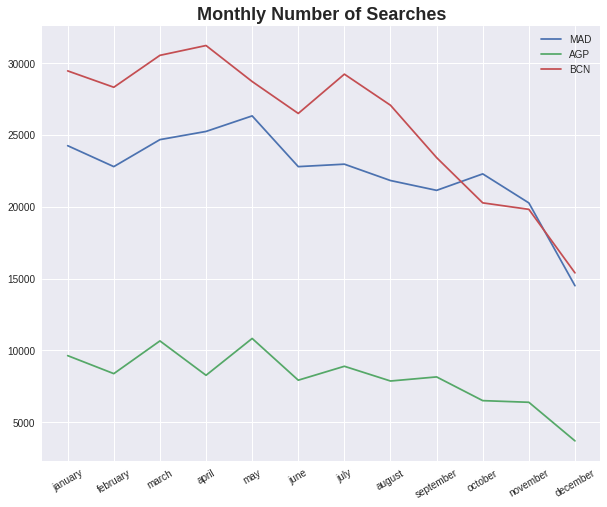

In [17]:
plt.style.use('seaborn')
fig, ax = plt.subplots(figsize=(10,8))

iata_codes = ['MAD', 'AGP', 'BCN']
for code in iata_codes:
    searches[searches['Destination'] == code].groupby('Date').agg([len]).plot(ax=ax)

ax.set_title('Monthly Number of Searches', 
             fontsize=18, 
             fontweight ='bold')

ax.set_xticks([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11])
months = ['january', 'february', 'march', 
          'april', 'may', 'june',
          'july', 'august', 'september', 
          'october', 'november', 'december']
ax.set_xticklabels(months, rotation=30)
ax.set_xlabel('')

leg = ax.legend(['MAD', 'AGP', 'BCN']);
ax.figure.savefig('exercise_3.png');

No entiendo por qué cuando hago el `reset_index` me cambia el color de las lineas pero no el de la `legend`. -> Preguntar

##### Option 2

In the second option we make a dataframe for each airport instead of an unique dataframe.

In [196]:
data_iterator = pd.read_csv("../challenge/searches.csv.bz2", 
                            chunksize=10**6, 
                            sep='^', 
                            usecols=['Date', 'Destination'],
                            compression='bz2',
                            #nrows=10**5
                           )

madrid_searches = pd.DataFrame()
barcelona_searches = pd.DataFrame()
malaga_searches = pd.DataFrame()

for i, data_chunk in enumerate(data_iterator):
    #print("Chunk: %d, size of chunk %d"%(i+1, len(data_chunk)))
    
    data_chunk = data_preprocessing(data_chunk)
    #data_chunk.reset_index(inplace=True)
    
    madrid_data_chunk = data_chunk[data_chunk['Destination'] == 'MAD']
    madrid_searches = madrid_searches.append(madrid_data_chunk)

    barcelona_data_chunk = data_chunk[data_chunk['Destination'] == 'BCN']
    barcelona_searches = barcelona_searches.append(barcelona_data_chunk)
    
    malaga_data_chunk = data_chunk[data_chunk['Destination'] == 'AGP']
    malaga_searches = malaga_searches.append(malaga_data_chunk)

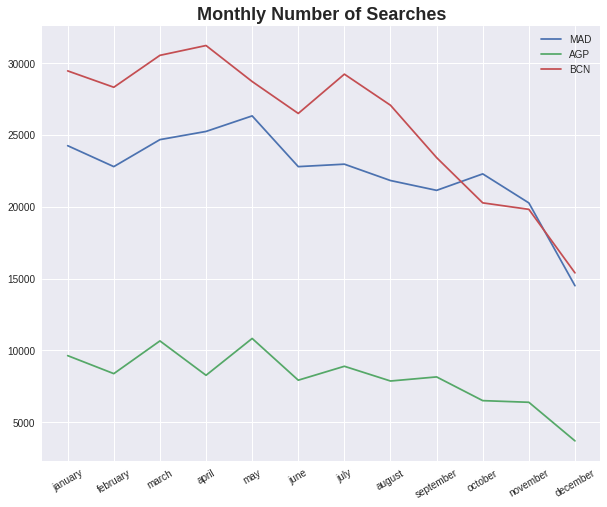

In [197]:
plt.style.use('seaborn')
fig, ax = plt.subplots(figsize=(10,8))

#madrid_searches['Date'].dt.month.value_counts().sort_index().plot(label='MAD')
#malaga_searches['Date'].dt.month.value_counts().sort_index().plot(label='AGP')
#barcelona_searches['Date'].dt.month.value_counts().sort_index().plot(label='BCN')
madrid_searches.groupby('Date').agg([len]).plot(ax=ax)
malaga_searches.groupby('Date').agg([len]).plot(ax=ax)
barcelona_searches.groupby('Date').agg([len]).plot(ax=ax)

ax.set_title('Monthly Number of Searches', 
             fontsize=18, 
             fontweight ='bold')

ax.set_xticks([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11])
months = ['january', 'february', 'march', 
          'april', 'may', 'june',
          'july', 'august', 'september', 
          'october', 'november', 'december']
ax.set_xticklabels(months, rotation=30)
ax.set_xlabel('')

leg = ax.legend(['MAD', 'AGP', 'BCN']);

------------------------------

### First Approximation 

In [3]:
searches = pd.read_csv('../challenge/searches.csv.bz2', nrows=10, sep='^', 
                       compression='bz2', parse_dates=['Date'])
searches.head()

,Date,Time,TxnCode,OfficeID,Country,Origin,Destination,RoundTrip,NbSegments,Seg1Departure,Seg1Arrival,Seg1Date,Seg1Carrier,Seg1BookingCode,Seg2Departure,Seg2Arrival,Seg2Date,Seg2Carrier,Seg2BookingCode,Seg3Departure,Seg3Arrival,Seg3Date,Seg3Carrier,Seg3BookingCode,Seg4Departure,Seg4Arrival,Seg4Date,Seg4Carrier,Seg4BookingCode,Seg5Departure,Seg5Arrival,Seg5Date,Seg5Carrier,Seg5BookingCode,Seg6Departure,Seg6Arrival,Seg6Date,Seg6Carrier,Seg6BookingCode,From,IsPublishedForNeg,IsFromInternet,IsFromVista,TerminalID,InternetOffice
0,2013-01-01,20:25:57,MPT,624d8c3ac0b3a7ca03e3c167e0f48327,DE,TXL,AUH,1,2,TXL,AUH,2013-01-26,D2,NaN,AUH,TXL,2013-02-02,D2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1ASIWS,0,0,0,d41d8cd98f00b204e9800998ecf8427e,FRA
1,2013-01-01,10:15:33,MPT,b0af35b31588dc4ab06d5cf2986e8e02,MD,ATH,MIL,0,1,ATH,MIL,2013-01-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1ASIWS,0,0,0,d41d8cd98f00b204e9800998ecf8427e,KIV
2,2013-01-01,18:04:49,MPT,3561a60621de06ab1badc8ca55699ef3,US,ICT,SFO,1,2,ICT,SFO,2013-08-02,NaN,NaN,SFO,ICT,2013-08-09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1ASIWS,0,0,0,d41d8cd98f00b204e9800998ecf8427e,NYC
3,2013-01-01,17:42:40,FXP,1864e5e8013d9414150e91d26b6a558b,SE,RNB,ARN,0,1,RNB,ARN,2013-01-02,DU,W,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1ASI,0,0,0,d41d8cd98f00b204e9800998ecf8427e,STO
4,2013-01-01,17:48:29,MPT,1ec336348f44207d2e0027dc3a68c118,NO,OSL,MAD,1,2,OSL,MAD,2013-03-22,NaN,NaN,MAD,OSL,2013-03-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1ASIWS,0,0,0,d41d8cd98f00b204e9800998ecf8427e,OSL


In [4]:
searches.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 45 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   Date               10 non-null     datetime64[ns]
 1   Time               10 non-null     object        
 2   TxnCode            10 non-null     object        
 3   OfficeID           10 non-null     object        
 4   Country            10 non-null     object        
 5   Origin             10 non-null     object        
 6   Destination        10 non-null     object        
 7   RoundTrip          10 non-null     int64         
 8   NbSegments         10 non-null     int64         
 9   Seg1Departure      10 non-null     object        
 10  Seg1Arrival        10 non-null     object        
 11  Seg1Date           10 non-null     object        
 12  Seg1Carrier        2 non-null      object        
 13  Seg1BookingCode    1 non-null      object        
 14  Seg2Departure

In [5]:
chunks = pd.read_csv('../challenge/searches.csv.bz2', chunksize=10**6,  
                     sep='^', compression='bz2', 
                     usecols=['Date', 'Destination'])

searches = pd.concat(chunks)

In [6]:
searches.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20390198 entries, 0 to 20390197
Data columns (total 2 columns):
 #   Column       Dtype 
---  ------       ----- 
 0   Date         object
 1   Destination  object
dtypes: object(2)
memory usage: 311.1+ MB


In [7]:
searches.head()

,Date,Destination
0,2013-01-01,AUH
1,2013-01-01,MIL
2,2013-01-01,SFO
3,2013-01-01,ARN
4,2013-01-01,MAD


In [38]:
searches['Date'] = pd.to_datetime(searches['Date'], errors='coerce')

In [9]:
searches.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20390198 entries, 0 to 20390197
Data columns (total 2 columns):
 #   Column       Dtype         
---  ------       -----         
 0   Date         datetime64[ns]
 1   Destination  object        
dtypes: datetime64[ns](1), object(1)
memory usage: 311.1+ MB


In [10]:
searches['Date'].isna().sum()

33

In [11]:
searches['Destination'].isna().sum()

33

In [12]:
searches.dropna(inplace=True)

In [13]:
searches['Date'].isna().sum()

0

In [21]:
searches['Destination'] = searches['Destination'].str.strip()

In [40]:
searches['Date'].dt.year.value_counts()

2013    20390165
Name: Date, dtype: int64

|City|IATA Code|
|:----:|:----:|
|Madrid|MAD|
|Málaga|AGP|
|Barcelona|BCN|

In [23]:
madrid_searches = searches[searches['Destination'] == 'MAD']
madrid_searches.head()

,Date,Destination
4,2013-01-01,MAD
151,2013-01-01,MAD
375,2013-01-01,MAD
406,2013-01-01,MAD
509,2013-01-01,MAD


In [24]:
malaga_searches = searches[searches['Destination'] == 'AGP']
malaga_searches.head()

,Date,Destination
93,2013-01-01,AGP
147,2013-01-01,AGP
242,2013-01-01,AGP
458,2013-01-01,AGP
674,2013-01-01,AGP


In [25]:
barcelona_searches = searches[searches['Destination'] == 'BCN']
barcelona_searches.head()

,Date,Destination
113,2013-01-01,BCN
165,2013-01-01,BCN
177,2013-01-01,BCN
186,2013-01-01,BCN
188,2013-01-01,BCN


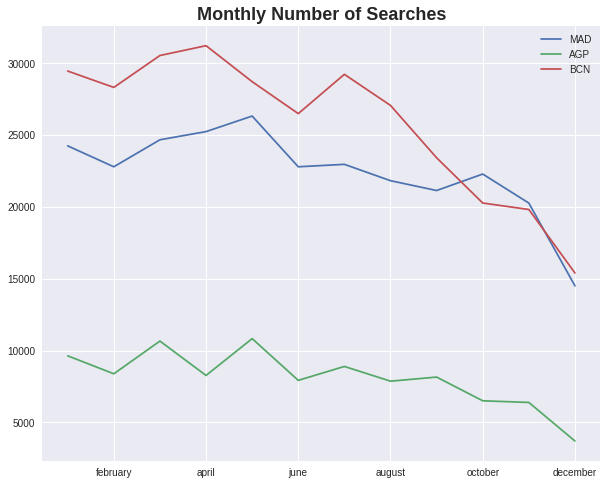

In [26]:
plt.style.use('seaborn')
fig, ax = plt.subplots(figsize=(10,8))

madrid_searches['Date'].dt.month.value_counts().sort_index().plot(label='MAD')
malaga_searches['Date'].dt.month.value_counts().sort_index().plot(label='AGP')
barcelona_searches['Date'].dt.month.value_counts().sort_index().plot(label='BCN')

ax.set_title('Monthly Number of Searches', 
             fontsize=18, 
             fontweight ='bold')

ax.set_xticks([2, 4, 6, 8, 10, 12])
months = ['february', 'april', 'june', 
          'august', 'october', 'december']
ax.set_xticklabels(months)

ax.legend();

# Exercise 4

**Match searches with bookings**

- For every search in the searches file, find out whether the search ended up in a booking or not (using the info in the bookings file). For instance, search and booking origin and destination should match.
- For the bookings file, origin and destination are the columns `dep_port` and `arr_port`, respectively.
- Generate a CSV file with the search data, and an additional field, containing 1 if the search ended up in a booking, and 0 otherwise.

In [248]:
searches = pd.read_csv('../challenge/searches.csv.bz2', nrows=10**6, sep='^', 
                       compression='bz2')#parse_dates=['Date']
searches.head()

/home/javi/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (44) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


,Date,Time,TxnCode,OfficeID,Country,Origin,Destination,RoundTrip,NbSegments,Seg1Departure,Seg1Arrival,Seg1Date,Seg1Carrier,Seg1BookingCode,Seg2Departure,Seg2Arrival,Seg2Date,Seg2Carrier,Seg2BookingCode,Seg3Departure,Seg3Arrival,Seg3Date,Seg3Carrier,Seg3BookingCode,Seg4Departure,Seg4Arrival,Seg4Date,Seg4Carrier,Seg4BookingCode,Seg5Departure,Seg5Arrival,Seg5Date,Seg5Carrier,Seg5BookingCode,Seg6Departure,Seg6Arrival,Seg6Date,Seg6Carrier,Seg6BookingCode,From,IsPublishedForNeg,IsFromInternet,IsFromVista,TerminalID,InternetOffice
0,2013-01-01,20:25:57,MPT,624d8c3ac0b3a7ca03e3c167e0f48327,DE,TXL,AUH,1,2,TXL,AUH,2013-01-26,D2,NaN,AUH,TXL,2013-02-02,D2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1ASIWS,0,0,0,d41d8cd98f00b204e9800998ecf8427e,FRA
1,2013-01-01,10:15:33,MPT,b0af35b31588dc4ab06d5cf2986e8e02,MD,ATH,MIL,0,1,ATH,MIL,2013-01-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1ASIWS,0,0,0,d41d8cd98f00b204e9800998ecf8427e,KIV
2,2013-01-01,18:04:49,MPT,3561a60621de06ab1badc8ca55699ef3,US,ICT,SFO,1,2,ICT,SFO,2013-08-02,NaN,NaN,SFO,ICT,2013-08-09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1ASIWS,0,0,0,d41d8cd98f00b204e9800998ecf8427e,NYC
3,2013-01-01,17:42:40,FXP,1864e5e8013d9414150e91d26b6a558b,SE,RNB,ARN,0,1,RNB,ARN,2013-01-02,DU,W,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1ASI,0,0,0,d41d8cd98f00b204e9800998ecf8427e,STO
4,2013-01-01,17:48:29,MPT,1ec336348f44207d2e0027dc3a68c118,NO,OSL,MAD,1,2,OSL,MAD,2013-03-22,NaN,NaN,MAD,OSL,2013-03-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1ASIWS,0,0,0,d41d8cd98f00b204e9800998ecf8427e,OSL


In [242]:
searches.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 45 columns):
 #   Column             Non-Null Count    Dtype 
---  ------             --------------    ----- 
 0   Date               1000000 non-null  object
 1   Time               1000000 non-null  object
 2   TxnCode            1000000 non-null  object
 3   OfficeID           1000000 non-null  object
 4   Country            999878 non-null   object
 5   Origin             1000000 non-null  object
 6   Destination        1000000 non-null  object
 7   RoundTrip          1000000 non-null  int64 
 8   NbSegments         1000000 non-null  int64 
 9   Seg1Departure      1000000 non-null  object
 10  Seg1Arrival        1000000 non-null  object
 11  Seg1Date           997115 non-null   object
 12  Seg1Carrier        375381 non-null   object
 13  Seg1BookingCode    102150 non-null   object
 14  Seg2Departure      709149 non-null   object
 15  Seg2Arrival        709149 non-null   object
 16  S

In [243]:
searches.iloc[0,0]

'2013-01-01'

In [245]:
searches.iloc[0,11]

'2013-01-26'

In [239]:
searches.columns.tolist()

['Date',
 'Time',
 'TxnCode',
 'OfficeID',
 'Country',
 'Origin',
 'Destination',
 'RoundTrip',
 'NbSegments',
 'Seg1Departure',
 'Seg1Arrival',
 'Seg1Date',
 'Seg1Carrier',
 'Seg1BookingCode',
 'Seg2Departure',
 'Seg2Arrival',
 'Seg2Date',
 'Seg2Carrier',
 'Seg2BookingCode',
 'Seg3Departure',
 'Seg3Arrival',
 'Seg3Date',
 'Seg3Carrier',
 'Seg3BookingCode',
 'Seg4Departure',
 'Seg4Arrival',
 'Seg4Date',
 'Seg4Carrier',
 'Seg4BookingCode',
 'Seg5Departure',
 'Seg5Arrival',
 'Seg5Date',
 'Seg5Carrier',
 'Seg5BookingCode',
 'Seg6Departure',
 'Seg6Arrival',
 'Seg6Date',
 'Seg6Carrier',
 'Seg6BookingCode',
 'From',
 'IsPublishedForNeg',
 'IsFromInternet',
 'IsFromVista',
 'TerminalID',
 'InternetOffice']

In [202]:
bookings.columns.tolist()

['act_date           ',
 'source',
 'pos_ctry',
 'pos_iata',
 'pos_oid  ',
 'rloc          ',
 'cre_date           ',
 'duration',
 'distance',
 'dep_port',
 'dep_city',
 'dep_ctry',
 'arr_port',
 'arr_city',
 'arr_ctry',
 'lst_port',
 'lst_city',
 'lst_ctry',
 'brd_port',
 'brd_city',
 'brd_ctry',
 'off_port',
 'off_city',
 'off_ctry',
 'mkt_port',
 'mkt_city',
 'mkt_ctry',
 'intl',
 'route          ',
 'carrier',
 'bkg_class',
 'cab_class',
 'brd_time           ',
 'off_time           ',
 'pax',
 'year',
 'month',
 'oid      ']

In [206]:
bookings = pd.read_csv('../challenge/bookings.csv.bz2', nrows=10**6, sep='^', 
                       compression='bz2', 
                      )
bookings.head()

,act_date,source,pos_ctry,pos_iata,pos_oid,rloc,cre_date,duration,distance,dep_port,dep_city,dep_ctry,arr_port,arr_city,arr_ctry,lst_port,lst_city,lst_ctry,brd_port,brd_city,brd_ctry,off_port,off_city,off_ctry,mkt_port,mkt_city,mkt_ctry,intl,route,carrier,bkg_class,cab_class,brd_time,off_time,pax,year,month,oid
0,2013-03-05 00:00:00,1A,DE,a68dd7ae953c8acfb187a1af2dcbe123,1a11ae49fcbf545fd2afc1a24d88d2b7,ea65900e72d71f4626378e2ebd298267,2013-02-22 00:00:00,1708,0,ZRH,ZRH,CH,LHR,LON,GB,ZRH,ZRH,CH,LHR,LON,GB,ZRH,ZRH,CH,LHRZRH,LONZRH,CHGB,1,LHRZRH,VI,T,Y,2013-03-07 08:50:00,2013-03-07 11:33:37,-1,2013,3,NULL
1,2013-03-26 00:00:00,1A,US,e612b9eeeee6f17f42d9b0d3b79e75ca,7437560d8f276d6d05eeb806d9e7edee,737295a86982c941f1c2da9a46a14043,2013-03-26 00:00:00,135270,0,SAL,SAL,SV,CLT,CLT,US,SAL,SAL,SV,SAL,SAL,SV,CLT,CLT,US,CLTSAL,CLTSAL,SVUS,1,SALATLCLT,NV,L,Y,2013-04-12 13:04:00,2013-04-12 22:05:40,1,2013,3,NULL
2,2013-03-26 00:00:00,1A,US,e612b9eeeee6f17f42d9b0d3b79e75ca,7437560d8f276d6d05eeb806d9e7edee,737295a86982c941f1c2da9a46a14043,2013-03-26 00:00:00,135270,0,SAL,SAL,SV,CLT,CLT,US,SAL,SAL,SV,CLT,CLT,US,SAL,SAL,SV,CLTSAL,CLTSAL,SVUS,1,CLTATLSAL,NV,U,Y,2013-07-15 07:00:00,2013-07-15 11:34:51,1,2013,3,NULL
3,2013-03-26 00:00:00,1A,AU,0f984b3bb6bd06661c95529bbd6193bc,36472c6dbaf7afec9136ac40364e2794,5ecf00fdcbcec761c43dc7285253d0c1,2013-03-26 00:00:00,30885,0,AKL,AKL,NZ,SVO,MOW,RU,AKL,AKL,NZ,AKL,AKL,NZ,SVO,MOW,RU,AKLSVO,AKLMOW,NZRU,1,AKLHKGSVO,XK,G,Y,2013-04-24 23:59:00,2013-04-25 16:06:31,1,2013,3,SYDA82546
4,2013-03-26 00:00:00,1A,AU,0f984b3bb6bd06661c95529bbd6193bc,36472c6dbaf7afec9136ac40364e2794,5ecf00fdcbcec761c43dc7285253d0c1,2013-03-26 00:00:00,30885,0,AKL,AKL,NZ,SVO,MOW,RU,AKL,AKL,NZ,SVO,MOW,RU,AKL,AKL,NZ,AKLSVO,AKLMOW,NZRU,1,SVOHKGAKL,XK,G,Y,2013-05-14 20:15:00,2013-05-16 10:44:50,1,2013,3,SYDA82546


In [246]:
bookings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 38 columns):
 #   Column     Non-Null Count    Dtype 
---  ------     --------------    ----- 
 0   act_date   1000000 non-null  object
 1   source     1000000 non-null  object
 2   pos_ctry   1000000 non-null  object
 3   pos_iata   1000000 non-null  object
 4   pos_oid    1000000 non-null  object
 5   rloc       1000000 non-null  object
 6   cre_date   1000000 non-null  object
 7   duration   1000000 non-null  int64 
 8   distance   1000000 non-null  int64 
 9   dep_port   1000000 non-null  object
 10  dep_city   1000000 non-null  object
 11  dep_ctry   1000000 non-null  object
 12  arr_port   1000000 non-null  object
 13  arr_city   1000000 non-null  object
 14  arr_ctry   1000000 non-null  object
 15  lst_port   1000000 non-null  object
 16  lst_city   1000000 non-null  object
 17  lst_ctry   1000000 non-null  object
 18  brd_port   1000000 non-null  object
 19  brd_city   1000000 non

In [210]:
bookings.columns = bookings.columns.str.strip()
bookings.columns.tolist()

['act_date',
 'source',
 'pos_ctry',
 'pos_iata',
 'pos_oid',
 'rloc',
 'cre_date',
 'duration',
 'distance',
 'dep_port',
 'dep_city',
 'dep_ctry',
 'arr_port',
 'arr_city',
 'arr_ctry',
 'lst_port',
 'lst_city',
 'lst_ctry',
 'brd_port',
 'brd_city',
 'brd_ctry',
 'off_port',
 'off_city',
 'off_ctry',
 'mkt_port',
 'mkt_city',
 'mkt_ctry',
 'intl',
 'route',
 'carrier',
 'bkg_class',
 'cab_class',
 'brd_time',
 'off_time',
 'pax',
 'year',
 'month',
 'oid']

In [211]:
bookings[['pos_iata', 'pos_oid', 'rloc']]

,pos_iata,pos_oid,rloc
0,a68dd7ae953c8acfb187a1af2dcbe123,1a11ae49fcbf545fd2afc1a24d88d2b7,ea65900e72d71f4626378e2ebd298267
1,e612b9eeeee6f17f42d9b0d3b79e75ca,7437560d8f276d6d05eeb806d9e7edee,737295a86982c941f1c2da9a46a14043
2,e612b9eeeee6f17f42d9b0d3b79e75ca,7437560d8f276d6d05eeb806d9e7edee,737295a86982c941f1c2da9a46a14043
3,0f984b3bb6bd06661c95529bbd6193bc,36472c6dbaf7afec9136ac40364e2794,5ecf00fdcbcec761c43dc7285253d0c1
4,0f984b3bb6bd06661c95529bbd6193bc,36472c6dbaf7afec9136ac40364e2794,5ecf00fdcbcec761c43dc7285253d0c1
...,...,...,...
999995,1a5585bef21f0bf8dc865a87843635f9,6ff8fd087f94799d7aed903683384775,3b339797f7eca14c24e8b7565da822c0
999996,1a5585bef21f0bf8dc865a87843635f9,6ff8fd087f94799d7aed903683384775,3b339797f7eca14c24e8b7565da822c0
999997,07e98d2fd3cd4b737266b99727f7faa8,e8741eaf2fa2f71f931475d18fa72096,2b22597bdad931843c3b1d5219836e07
999998,e2679367673d50f1ee085127d8a00eba,5f26f53ca29672815e0ee3bd93a2b0e4,4eb40315a7263131ae17712cd505b62a


In [226]:
bookings['pos_iata'] = bookings['pos_iata'].str.strip()
bookings['pos_oid'] = bookings['pos_oid'].str.strip()
bookings['rloc'] = bookings['rloc'].str.strip()

In [230]:
bookings[['pos_iata', 'pos_oid', 'rloc']].isin([searches.iloc[100,3]]).sum()

pos_iata     0
pos_oid     35
rloc         0
dtype: int64

In [228]:
[searches.iloc[10,3]]

['b2771a31dc32d1e4af0ea7d758b8442b']

Parece que no nos sirven esas columnas, habia que intentarlo 

|searches|bookings|
|:---:|:---:|
|Seg`n`Departure|dep_port|
|Seg`n`Arrival|arr_port|
|Seg`n`Date|brd_time|
|Date|cre_date|

In [3]:
searches = pd.read_csv('../challenge/searches.csv.bz2', 
                       nrows = 10**6, 
                       sep = '^', 
                       compression = 'bz2',
                       #usecols = ['Date', 
                        #              'Seg1Date', 
                         #             'Seg1Departure', 
                          #            'Seg1Arrival']
                      )#parse_dates=['Date']


bookings = pd.read_csv('../challenge/bookings.csv.bz2', 
                       nrows=10**6, 
                       sep='^', 
                       compression='bz2', 
                       #usecols = ['dep_port', 
                        #              'arr_port', 
                         #             'brd_time           ', 
                          #            'cre_date           ']
                      )

/home/javi/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (44) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [111]:
searches.head(2)

,Date,Time,TxnCode,OfficeID,Country,Origin,Destination,RoundTrip,NbSegments,Seg1Departure,Seg1Arrival,Seg1Date,Seg1Carrier,Seg1BookingCode,Seg2Departure,Seg2Arrival,Seg2Date,Seg2Carrier,Seg2BookingCode,Seg3Departure,Seg3Arrival,Seg3Date,Seg3Carrier,Seg3BookingCode,Seg4Departure,Seg4Arrival,Seg4Date,Seg4Carrier,Seg4BookingCode,Seg5Departure,Seg5Arrival,Seg5Date,Seg5Carrier,Seg5BookingCode,Seg6Departure,Seg6Arrival,Seg6Date,Seg6Carrier,Seg6BookingCode,From,IsPublishedForNeg,IsFromInternet,IsFromVista,TerminalID,InternetOffice
0,2013-01-01,20:25:57,MPT,624d8c3ac0b3a7ca03e3c167e0f48327,DE,TXL,AUH,1,2,TXL,AUH,2013-01-26,D2,NaN,AUH,TXL,2013-02-02,D2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1ASIWS,0,0,0,d41d8cd98f00b204e9800998ecf8427e,FRA
1,2013-01-01,10:15:33,MPT,b0af35b31588dc4ab06d5cf2986e8e02,MD,ATH,MIL,0,1,ATH,MIL,2013-01-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1ASIWS,0,0,0,d41d8cd98f00b204e9800998ecf8427e,KIV


In [112]:
bookings.head(2)

,act_date,source,pos_ctry,pos_iata,pos_oid,rloc,cre_date,duration,distance,dep_port,dep_city,dep_ctry,arr_port,arr_city,arr_ctry,lst_port,lst_city,lst_ctry,brd_port,brd_city,brd_ctry,off_port,off_city,off_ctry,mkt_port,mkt_city,mkt_ctry,intl,route,carrier,bkg_class,cab_class,brd_time,off_time,pax,year,month,oid
0,2013-03-05 00:00:00,1A,DE,a68dd7ae953c8acfb187a1af2dcbe123,1a11ae49fcbf545fd2afc1a24d88d2b7,ea65900e72d71f4626378e2ebd298267,2013-02-22 00:00:00,1708,0,ZRH,ZRH,CH,LHR,LON,GB,ZRH,ZRH,CH,LHR,LON,GB,ZRH,ZRH,CH,LHRZRH,LONZRH,CHGB,1,LHRZRH,VI,T,Y,2013-03-07 08:50:00,2013-03-07 11:33:37,-1,2013,3,NULL
1,2013-03-26 00:00:00,1A,US,e612b9eeeee6f17f42d9b0d3b79e75ca,7437560d8f276d6d05eeb806d9e7edee,737295a86982c941f1c2da9a46a14043,2013-03-26 00:00:00,135270,0,SAL,SAL,SV,CLT,CLT,US,SAL,SAL,SV,SAL,SAL,SV,CLT,CLT,US,CLTSAL,CLTSAL,SVUS,1,SALATLCLT,NV,L,Y,2013-04-12 13:04:00,2013-04-12 22:05:40,1,2013,3,NULL


In [113]:
(searches['Origin'] != searches['Seg1Departure']).sum() # para verificar que son lo mimso

0

In [114]:
bookings.isna().sum()

act_date               0
source                 0
pos_ctry               0
pos_iata               0
pos_oid                0
rloc                   0
cre_date               0
duration               0
distance               0
dep_port               0
dep_city               0
dep_ctry               0
arr_port               0
arr_city               0
arr_ctry               0
lst_port               0
lst_city               0
lst_ctry               0
brd_port               0
brd_city               0
brd_ctry               0
off_port               0
off_city               0
off_ctry               0
mkt_port               0
mkt_city               0
mkt_ctry               0
intl                   0
route                  0
carrier                0
bkg_class              0
cab_class              0
brd_time               0
off_time               0
pax                    0
year                   0
month                  0
oid                    0
dtype: int64

In [115]:
searches.isna().sum()

Date                      0
Time                      0
TxnCode                   0
OfficeID                  0
Country                 122
Origin                    0
Destination               0
RoundTrip                 0
NbSegments                0
Seg1Departure             0
Seg1Arrival               0
Seg1Date               2885
Seg1Carrier          624619
Seg1BookingCode      897850
Seg2Departure        290851
Seg2Arrival          290851
Seg2Date             294285
Seg2Carrier          739321
Seg2BookingCode      912249
Seg3Departure        948090
Seg3Arrival          948090
Seg3Date             948400
Seg3Carrier          950617
Seg3BookingCode      952703
Seg4Departure        957956
Seg4Arrival          957956
Seg4Date             958231
Seg4Carrier          958304
Seg4BookingCode      958823
Seg5Departure        991993
Seg5Arrival          991993
Seg5Date             992064
Seg5Carrier          992035
Seg5BookingCode      992160
Seg6Departure        995209
Seg6Arrival         

No se si me cuadra del todo usar estas columnas 
Parece que cada search podria terminar en varias bookings, hasta 6
Usamos `cre_date` en lugar de `act_date` porque `cre_date` es anterior, y la fecha de creacion de la reserva debe ser la anterior.

In [61]:
searches.duplicated().sum()

636657

Cuando hago esa ultima por chunks los numeros cambian un poco

In [117]:
searches.tail()

,Date,Time,TxnCode,OfficeID,Country,Origin,Destination,RoundTrip,NbSegments,Seg1Departure,Seg1Arrival,Seg1Date,Seg1Carrier,Seg1BookingCode,Seg2Departure,Seg2Arrival,Seg2Date,Seg2Carrier,Seg2BookingCode,Seg3Departure,Seg3Arrival,Seg3Date,Seg3Carrier,Seg3BookingCode,Seg4Departure,Seg4Arrival,Seg4Date,Seg4Carrier,Seg4BookingCode,Seg5Departure,Seg5Arrival,Seg5Date,Seg5Carrier,Seg5BookingCode,Seg6Departure,Seg6Arrival,Seg6Date,Seg6Carrier,Seg6BookingCode,From,IsPublishedForNeg,IsFromInternet,IsFromVista,TerminalID,InternetOffice
999995,2013-10-09,06:33:40,FXA,0ae4fec5a2d9c17fb33b32343ef17ef2,AU,ADL,MEL,0,2,ADL,MEL,2013-10-27,GK,J,MEL,CBR,2013-10-27,GK,J,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1ASI,0,0,0,537c4fd32d4068dd358b24fbd82bc7e0,0
999996,2013-10-09,14:44:05,MPT,7d8850b517b997d2261756d0c42e412e,TR,IST,LAS,1,2,IST,LAS,2013-10-10,NaN,NaN,LAS,IST,2013-10-15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1ASI,0,0,0,d41d8cd98f00b204e9800998ecf8427e,0
999997,2013-10-09,05:39:47,MPT,4caf98fe1b209342883e5bbf5a81cd1f,DK,CPH,AGP,0,1,CPH,AGP,2014-01-19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1ASIWS,0,0,0,d41d8cd98f00b204e9800998ecf8427e,0
999998,2013-10-09,08:15:30,MPT,eee76fcf858b70383b482882bcb36880,GB,LON,BJS,1,2,LON,BJS,2014-05-16,NaN,NaN,BJS,LON,2014-05-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1ASIWS,0,0,0,d41d8cd98f00b204e9800998ecf8427e,0
999999,2013-10-09,15:24:04,MPT,8a920c89312c383c860f9faf2e693b84,IT,STO,PAR,1,2,STO,PAR,2013-10-17,NaN,NaN,PAR,STO,2013-10-21,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1ASIWS,0,0,0,d41d8cd98f00b204e9800998ecf8427e,0


In [118]:
bookings.duplicated().sum()

0

Deberiamos eliminar las busquedas repetidas, no tiene sentido mantenerlas 

In [119]:
searches.drop_duplicates(inplace=True)
searches.shape

(363343, 45)

Tambien deberiamos eliminarlas en bookings porque cuando cargemos todas las filas igual si que salen duplicadso

In [120]:
bookings.drop_duplicates(inplace=True)
bookings.shape

(1000000, 38)

Ahora que hemos eliminado las filas duplicadas podemos deshacernos de las columnas que no necesitamos.

----------------

Esto estaba mal, necesitaremos todas las columnas en searches porque tenemos que guardarlas al final

Ahora usamos esa lista para eliminar las columnas que no queremos

----------------

Ahora eliminemos las columnas que no queremos de bookings. 

No podria cargar el dataset solo con las columnas que quiero porque podrian salir muchos mas duplicados.

In [121]:
bookings.columns = bookings.columns.str.strip()
bookings.columns.tolist()

['act_date',
 'source',
 'pos_ctry',
 'pos_iata',
 'pos_oid',
 'rloc',
 'cre_date',
 'duration',
 'distance',
 'dep_port',
 'dep_city',
 'dep_ctry',
 'arr_port',
 'arr_city',
 'arr_ctry',
 'lst_port',
 'lst_city',
 'lst_ctry',
 'brd_port',
 'brd_city',
 'brd_ctry',
 'off_port',
 'off_city',
 'off_ctry',
 'mkt_port',
 'mkt_city',
 'mkt_ctry',
 'intl',
 'route',
 'carrier',
 'bkg_class',
 'cab_class',
 'brd_time',
 'off_time',
 'pax',
 'year',
 'month',
 'oid']

In [122]:
drop_bookings = bookings.columns.tolist()
drop_bookings

['act_date',
 'source',
 'pos_ctry',
 'pos_iata',
 'pos_oid',
 'rloc',
 'cre_date',
 'duration',
 'distance',
 'dep_port',
 'dep_city',
 'dep_ctry',
 'arr_port',
 'arr_city',
 'arr_ctry',
 'lst_port',
 'lst_city',
 'lst_ctry',
 'brd_port',
 'brd_city',
 'brd_ctry',
 'off_port',
 'off_city',
 'off_ctry',
 'mkt_port',
 'mkt_city',
 'mkt_ctry',
 'intl',
 'route',
 'carrier',
 'bkg_class',
 'cab_class',
 'brd_time',
 'off_time',
 'pax',
 'year',
 'month',
 'oid']

In [123]:
for column in ['cre_date', 'dep_port', 'arr_port', 'brd_time']:
    drop_bookings.remove(column)
len(drop_bookings)

34

In [124]:
bookings.drop(columns=drop_bookings, inplace=True)
print(bookings.shape)
bookings.head(2)

(1000000, 4)


,cre_date,dep_port,arr_port,brd_time
0,2013-02-22 00:00:00,ZRH,LHR,2013-03-07 08:50:00
1,2013-03-26 00:00:00,SAL,CLT,2013-04-12 13:04:00


#### Cleaning columns

In [125]:
searches.columns.tolist()

['Date',
 'Time',
 'TxnCode',
 'OfficeID',
 'Country',
 'Origin',
 'Destination',
 'RoundTrip',
 'NbSegments',
 'Seg1Departure',
 'Seg1Arrival',
 'Seg1Date',
 'Seg1Carrier',
 'Seg1BookingCode',
 'Seg2Departure',
 'Seg2Arrival',
 'Seg2Date',
 'Seg2Carrier',
 'Seg2BookingCode',
 'Seg3Departure',
 'Seg3Arrival',
 'Seg3Date',
 'Seg3Carrier',
 'Seg3BookingCode',
 'Seg4Departure',
 'Seg4Arrival',
 'Seg4Date',
 'Seg4Carrier',
 'Seg4BookingCode',
 'Seg5Departure',
 'Seg5Arrival',
 'Seg5Date',
 'Seg5Carrier',
 'Seg5BookingCode',
 'Seg6Departure',
 'Seg6Arrival',
 'Seg6Date',
 'Seg6Carrier',
 'Seg6BookingCode',
 'From',
 'IsPublishedForNeg',
 'IsFromInternet',
 'IsFromVista',
 'TerminalID',
 'InternetOffice']

Limpiaremos las columnas que necesitamos para el merge

In [128]:
searches_columns = ['Date', 'Seg1Departure', 'Seg1Arrival', 'Seg1Date']

for column in searches_columns:
    searches[column] = searches[column].str.strip()

    if 'Date' not in column:
        searches[column] = searches[column].str.upper()
        
        cell_length = (searches[column].map(len) != 3).sum()
        if cell_length != 0:
            print(f'Alert! There are `{column}` values with length different than 3, check it.')

In [129]:
searches.head(2)

,Date,Time,TxnCode,OfficeID,Country,Origin,Destination,RoundTrip,NbSegments,Seg1Departure,Seg1Arrival,Seg1Date,Seg1Carrier,Seg1BookingCode,Seg2Departure,Seg2Arrival,Seg2Date,Seg2Carrier,Seg2BookingCode,Seg3Departure,Seg3Arrival,Seg3Date,Seg3Carrier,Seg3BookingCode,Seg4Departure,Seg4Arrival,Seg4Date,Seg4Carrier,Seg4BookingCode,Seg5Departure,Seg5Arrival,Seg5Date,Seg5Carrier,Seg5BookingCode,Seg6Departure,Seg6Arrival,Seg6Date,Seg6Carrier,Seg6BookingCode,From,IsPublishedForNeg,IsFromInternet,IsFromVista,TerminalID,InternetOffice
0,2013-01-01,20:25:57,MPT,624D8C3AC0B3A7CA03E3C167E0F48327,DE,TXL,AUH,1,2,TXL,AUH,2013-01-26,D2,NaN,AUH,TXL,2013-02-02,D2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1ASIWS,0,0,0,d41d8cd98f00b204e9800998ecf8427e,FRA
1,2013-01-01,10:15:33,MPT,B0AF35B31588DC4AB06D5CF2986E8E02,MD,ATH,MIL,0,1,ATH,MIL,2013-01-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1ASIWS,0,0,0,d41d8cd98f00b204e9800998ecf8427e,KIV


In [130]:
bookings.columns.tolist()

['cre_date', 'dep_port', 'arr_port', 'brd_time']

In [131]:
bookings_columns = bookings.columns.tolist()

for column in bookings_columns:
    bookings[column] = bookings[column].str.strip()

    if 'port' in column:
        bookings[column] = bookings[column].str.upper()
        
        cell_length = (bookings[column].map(len) != 3).sum()
        if cell_length != 0:
            print(f'Alert! There are `{column}` values with length different than 3, check it.')
    else:
        bookings[column] = bookings[column].str.split().str[0]

In [132]:
bookings.head(2)

,cre_date,dep_port,arr_port,brd_time
0,2013-02-22,ZRH,LHR,2013-03-07
1,2013-03-26,SAL,CLT,2013-04-12


In [133]:
bookings.isna().sum()

cre_date    0
dep_port    0
arr_port    0
brd_time    0
dtype: int64

In [134]:
searches.isna().sum()

Date                      0
Time                      0
TxnCode                   0
OfficeID                  0
Country                  43
Origin                    0
Destination               0
RoundTrip                 0
NbSegments                0
Seg1Departure             0
Seg1Arrival               0
Seg1Date               1034
Seg1Carrier          226260
Seg1BookingCode      326321
Seg2Departure        105403
Seg2Arrival          105403
Seg2Date             106632
Seg2Carrier          268028
Seg2BookingCode      331522
Seg3Departure        344410
Seg3Arrival          344410
Seg3Date             344518
Seg3Carrier          345343
Seg3BookingCode      346164
Seg4Departure        348084
Seg4Arrival          348084
Seg4Date             348180
Seg4Carrier          348212
Seg4BookingCode      348412
Seg5Departure        360434
Seg5Arrival          360434
Seg5Date             360458
Seg5Carrier          360450
Seg5BookingCode      360497
Seg6Departure        361608
Seg6Arrival         

#### Primer intento de merge

|searches|bookings|
|:---:|:---:|
|Seg1Departure|dep_port|
|Seg1Arrival|arr_port|
|Seg1Date|brd_time|
|Date|cre_date|

Vamos a hacer copias de los dataframes para trabajar con ellas y asi si tenemos que empezar de nuevo no hara falta cargar todo de nuevo.

In [135]:
bookings['booking'] = 1
print(bookings.shape)
bookings_to_merge = bookings.copy()
bookings_to_merge.head(2)

(1000000, 5)


,cre_date,dep_port,arr_port,brd_time,booking
0,2013-02-22,ZRH,LHR,2013-03-07,1
1,2013-03-26,SAL,CLT,2013-04-12,1


In [136]:
searches_to_merge = searches.copy()
searches_to_merge.head(2)

,Date,Time,TxnCode,OfficeID,Country,Origin,Destination,RoundTrip,NbSegments,Seg1Departure,Seg1Arrival,Seg1Date,Seg1Carrier,Seg1BookingCode,Seg2Departure,Seg2Arrival,Seg2Date,Seg2Carrier,Seg2BookingCode,Seg3Departure,Seg3Arrival,Seg3Date,Seg3Carrier,Seg3BookingCode,Seg4Departure,Seg4Arrival,Seg4Date,Seg4Carrier,Seg4BookingCode,Seg5Departure,Seg5Arrival,Seg5Date,Seg5Carrier,Seg5BookingCode,Seg6Departure,Seg6Arrival,Seg6Date,Seg6Carrier,Seg6BookingCode,From,IsPublishedForNeg,IsFromInternet,IsFromVista,TerminalID,InternetOffice
0,2013-01-01,20:25:57,MPT,624D8C3AC0B3A7CA03E3C167E0F48327,DE,TXL,AUH,1,2,TXL,AUH,2013-01-26,D2,NaN,AUH,TXL,2013-02-02,D2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1ASIWS,0,0,0,d41d8cd98f00b204e9800998ecf8427e,FRA
1,2013-01-01,10:15:33,MPT,B0AF35B31588DC4AB06D5CF2986E8E02,MD,ATH,MIL,0,1,ATH,MIL,2013-01-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1ASIWS,0,0,0,d41d8cd98f00b204e9800998ecf8427e,KIV


Aqui vamos a darle a bookings_to_merge los mismos nombres de columnas que searches_to_merge, lo cual falicitara las cosas en el merge.

In [137]:
bookings_to_merge.columns

Index(['cre_date', 'dep_port', 'arr_port', 'brd_time', 'booking'], dtype='object')

In [139]:
searches_to_merge.columns.tolist()

['Date',
 'Time',
 'TxnCode',
 'OfficeID',
 'Country',
 'Origin',
 'Destination',
 'RoundTrip',
 'NbSegments',
 'Seg1Departure',
 'Seg1Arrival',
 'Seg1Date',
 'Seg1Carrier',
 'Seg1BookingCode',
 'Seg2Departure',
 'Seg2Arrival',
 'Seg2Date',
 'Seg2Carrier',
 'Seg2BookingCode',
 'Seg3Departure',
 'Seg3Arrival',
 'Seg3Date',
 'Seg3Carrier',
 'Seg3BookingCode',
 'Seg4Departure',
 'Seg4Arrival',
 'Seg4Date',
 'Seg4Carrier',
 'Seg4BookingCode',
 'Seg5Departure',
 'Seg5Arrival',
 'Seg5Date',
 'Seg5Carrier',
 'Seg5BookingCode',
 'Seg6Departure',
 'Seg6Arrival',
 'Seg6Date',
 'Seg6Carrier',
 'Seg6BookingCode',
 'From',
 'IsPublishedForNeg',
 'IsFromInternet',
 'IsFromVista',
 'TerminalID',
 'InternetOffice']

In [140]:
new_columns_bookings = ['Date', 
                        'Seg1Departure', 
                        'Seg1Arrival', 
                        'Seg1Date', 
                        'Booking']
new_columns_bookings

['Date', 'Seg1Departure', 'Seg1Arrival', 'Seg1Date', 'Booking']

In [141]:
bookings_to_merge.columns = new_columns_bookings
bookings_to_merge.head(2)

,Date,Seg1Departure,Seg1Arrival,Seg1Date,Booking
0,2013-02-22,ZRH,LHR,2013-03-07,1
1,2013-03-26,SAL,CLT,2013-04-12,1


Miremos los duplicados ahora.

In [142]:
bookings_to_merge.duplicated().sum()

341002

In [143]:
searches_to_merge.duplicated().sum()

0

Ya nos habiamos quitado los duplicados pero ahora hay mas porque hemos eliminado muchas columnas. Que deberiamos hacer? Borrar los duplicados? Dejarlos?

Echemos un vistazo a como tratamos los duplicados mas arriba:

![](../images/image_duplicates.png)

Bookings ni siquiera tenia duplicados, y ahora tiene un tercio. Que desastre

Si eliminamos esos duplicados estaremos perdiendo informacion porque no eran duplicados cuando estudiamos si habian duplicados teniendo todas las columnas.

Hagamos una pruebecilla rapida

In [158]:
lista1 = [[2, 4], 
          [2, 4], 
          [2, 4], 
          [1, 5], 
          [1, 6]]

df1 = pd.DataFrame(lista1, columns=['cero', 'uno'])
df1

,cero,uno
0,2,4
1,2,4
2,2,4
3,1,5
4,1,6


In [165]:
lista2 = [[2, 4, 1], 
          [2, 4, 1], 
          [1, 5, 1]]

df2 = pd.DataFrame(lista2, columns=['cero', 'uno', 'dos'])
df2

,cero,uno,dos
0,2,4,1
1,2,4,1
2,1,5,1


In [166]:
df = df1.merge(df2, 
               how='left',
               #left_on=['cero', 'uno'],
               #right_on=['cero_', 'uno_'],
               indicator=True
              )
df

,cero,uno,dos,_merge
0,2,4,1.0,both
1,2,4,1.0,both
2,2,4,1.0,both
3,2,4,1.0,both
4,2,4,1.0,both
5,2,4,1.0,both
6,1,5,1.0,both
7,1,6,NaN,left_only


Si estamos estudiando solo los Seg1 dentro de searches, solo podemos tener 1 match con cada uno.

In [151]:
searches_to_merge.shape

(363343, 45)

In [152]:
bookings_to_merge.shape

(1000000, 5)

In [169]:
combined = searches_to_merge.merge(bookings_to_merge, 
                                   how='left',
                                  )

In [170]:
combined

,Date,Time,TxnCode,OfficeID,Country,Origin,Destination,RoundTrip,NbSegments,Seg1Departure,Seg1Arrival,Seg1Date,Seg1Carrier,Seg1BookingCode,Seg2Departure,Seg2Arrival,Seg2Date,Seg2Carrier,Seg2BookingCode,Seg3Departure,Seg3Arrival,Seg3Date,Seg3Carrier,Seg3BookingCode,Seg4Departure,Seg4Arrival,Seg4Date,Seg4Carrier,Seg4BookingCode,Seg5Departure,Seg5Arrival,Seg5Date,Seg5Carrier,Seg5BookingCode,Seg6Departure,Seg6Arrival,Seg6Date,Seg6Carrier,Seg6BookingCode,From,IsPublishedForNeg,IsFromInternet,IsFromVista,TerminalID,InternetOffice,Booking
0,2013-01-01,20:25:57,MPT,624D8C3AC0B3A7CA03E3C167E0F48327,DE,TXL,AUH,1,2,TXL,AUH,2013-01-26,D2,NaN,AUH,TXL,2013-02-02,D2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1ASIWS,0,0,0,d41d8cd98f00b204e9800998ecf8427e,FRA,NaN
1,2013-01-01,10:15:33,MPT,B0AF35B31588DC4AB06D5CF2986E8E02,MD,ATH,MIL,0,1,ATH,MIL,2013-01-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1ASIWS,0,0,0,d41d8cd98f00b204e9800998ecf8427e,KIV,NaN
2,2013-01-01,18:04:49,MPT,3561A60621DE06AB1BADC8CA55699EF3,US,ICT,SFO,1,2,ICT,SFO,2013-08-02,NaN,NaN,SFO,ICT,2013-08-09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1ASIWS,0,0,0,d41d8cd98f00b204e9800998ecf8427e,NYC,NaN
3,2013-01-01,17:42:40,FXP,1864E5E8013D9414150E91D26B6A558B,SE,RNB,ARN,0,1,RNB,ARN,2013-01-02,DU,W,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1ASI,0,0,0,d41d8cd98f00b204e9800998ecf8427e,STO,NaN
4,2013-01-01,17:48:29,MPT,1EC336348F44207D2E0027DC3A68C118,NO,OSL,MAD,1,2,OSL,MAD,2013-03-22,NaN,NaN,MAD,OSL,2013-03-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1ASIWS,0,0,0,d41d8cd98f00b204e9800998ecf8427e,OSL,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
363585,2013-08-04,07:14:59,MPT,D03A30F66F773A65AAD66E7BAFD1110F,GR,DXB,IST,1,2,DXB,IST,2013-08-18,NaN,NaN,IST,DXB,2013-08-21,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1ASI,0,0,0,d41d8cd98f00b204e9800998ecf8427e,0,NaN
363586,2013-08-04,07:34:47,MPT,1EE479F5D8E435942D95363363634AEE,DE,FRA,SUF,1,2,FRA,SUF,2013-10-19,NaN,NaN,SUF,FRA,2013-10-26,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1ASIWS,0,0,0,d41d8cd98f00b204e9800998ecf8427e,0,NaN
363587,2013-08-04,12:57:04,MPT,D8CFDEAA1E5442B0FB728A71485F426C,ES,BCN,PAR,0,1,BCN,PAR,2013-08-23,AD,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1ASIWS,0,0,0,d41d8cd98f00b204e9800998ecf8427e,0,NaN
363588,2013-08-04,15:27:20,MPT,0A914CFB66B849DDDAA6BB2E66FF0999,DE,KTW,NYC,1,2,KTW,NYC,2013-09-25,NaN,NaN,NYC,KTW,2013-10-07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1ASIWS,0,0,0,d41d8cd98f00b204e9800998ecf8427e,0,NaN


In [174]:
combined['Booking'].sum()

699.0

In [185]:
searches_to_merge.shape[0] - combined.shape[0]

-247

In [175]:
363590 - 363343

247

No me cuadra que aumente el numero de filas, probemos eliminando las nuevas filas duplicadas en bookings.

------------------

Hagamos dos nuevas copias para no usar las anteriores, por si retomamos en ese punto.

In [176]:
bookings_to_merge.duplicated().sum()

341002

In [177]:
searches_to_merge.duplicated().sum()

0

In [180]:
searches_to_merge.shape

(363343, 45)

In [179]:
bookings_to_merge_2 = bookings_to_merge.copy()
bookings_to_merge_2.duplicated().sum()

341002

In [181]:
searches_to_merge_2 = searches_to_merge.copy()
searches_to_merge_2.shape

(363343, 45)

In [183]:
bookings_to_merge_2.shape[0] - bookings_to_merge_2.duplicated().sum()

658998

In [184]:
bookings_to_merge_2.drop_duplicates(inplace=True)
print(bookings_to_merge_2.shape)
bookings_to_merge_2.duplicated().sum()

(658998, 5)


0

Ahora hacemos el merge

In [186]:
combined_2 = searches_to_merge_2.merge(bookings_to_merge_2, 
                                       how='left',
                                      )

In [190]:
combined_2

,Date,Time,TxnCode,OfficeID,Country,Origin,Destination,RoundTrip,NbSegments,Seg1Departure,Seg1Arrival,Seg1Date,Seg1Carrier,Seg1BookingCode,Seg2Departure,Seg2Arrival,Seg2Date,Seg2Carrier,Seg2BookingCode,Seg3Departure,Seg3Arrival,Seg3Date,Seg3Carrier,Seg3BookingCode,Seg4Departure,Seg4Arrival,Seg4Date,Seg4Carrier,Seg4BookingCode,Seg5Departure,Seg5Arrival,Seg5Date,Seg5Carrier,Seg5BookingCode,Seg6Departure,Seg6Arrival,Seg6Date,Seg6Carrier,Seg6BookingCode,From,IsPublishedForNeg,IsFromInternet,IsFromVista,TerminalID,InternetOffice,Booking
0,2013-01-01,20:25:57,MPT,624D8C3AC0B3A7CA03E3C167E0F48327,DE,TXL,AUH,1,2,TXL,AUH,2013-01-26,D2,NaN,AUH,TXL,2013-02-02,D2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1ASIWS,0,0,0,d41d8cd98f00b204e9800998ecf8427e,FRA,NaN
1,2013-01-01,10:15:33,MPT,B0AF35B31588DC4AB06D5CF2986E8E02,MD,ATH,MIL,0,1,ATH,MIL,2013-01-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1ASIWS,0,0,0,d41d8cd98f00b204e9800998ecf8427e,KIV,NaN
2,2013-01-01,18:04:49,MPT,3561A60621DE06AB1BADC8CA55699EF3,US,ICT,SFO,1,2,ICT,SFO,2013-08-02,NaN,NaN,SFO,ICT,2013-08-09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1ASIWS,0,0,0,d41d8cd98f00b204e9800998ecf8427e,NYC,NaN
3,2013-01-01,17:42:40,FXP,1864E5E8013D9414150E91D26B6A558B,SE,RNB,ARN,0,1,RNB,ARN,2013-01-02,DU,W,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1ASI,0,0,0,d41d8cd98f00b204e9800998ecf8427e,STO,NaN
4,2013-01-01,17:48:29,MPT,1EC336348F44207D2E0027DC3A68C118,NO,OSL,MAD,1,2,OSL,MAD,2013-03-22,NaN,NaN,MAD,OSL,2013-03-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1ASIWS,0,0,0,d41d8cd98f00b204e9800998ecf8427e,OSL,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
363338,2013-08-04,07:14:59,MPT,D03A30F66F773A65AAD66E7BAFD1110F,GR,DXB,IST,1,2,DXB,IST,2013-08-18,NaN,NaN,IST,DXB,2013-08-21,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1ASI,0,0,0,d41d8cd98f00b204e9800998ecf8427e,0,NaN
363339,2013-08-04,07:34:47,MPT,1EE479F5D8E435942D95363363634AEE,DE,FRA,SUF,1,2,FRA,SUF,2013-10-19,NaN,NaN,SUF,FRA,2013-10-26,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1ASIWS,0,0,0,d41d8cd98f00b204e9800998ecf8427e,0,NaN
363340,2013-08-04,12:57:04,MPT,D8CFDEAA1E5442B0FB728A71485F426C,ES,BCN,PAR,0,1,BCN,PAR,2013-08-23,AD,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1ASIWS,0,0,0,d41d8cd98f00b204e9800998ecf8427e,0,NaN
363341,2013-08-04,15:27:20,MPT,0A914CFB66B849DDDAA6BB2E66FF0999,DE,KTW,NYC,1,2,KTW,NYC,2013-09-25,NaN,NaN,NYC,KTW,2013-10-07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1ASIWS,0,0,0,d41d8cd98f00b204e9800998ecf8427e,0,NaN


In [192]:
combined_2.shape

(363343, 46)

In [193]:
combined_2['Booking'].sum()

452.0

In [194]:
searches_to_merge.shape[0] - combined_2.shape[0]

0

Esta vez no ha aumentado el numero de filas. Ahora habria que seguir con los merges con Seg2, Seg3 etc..

In [197]:
combined_2.isna().sum()

Date                      0
Time                      0
TxnCode                   0
OfficeID                  0
Country                  43
Origin                    0
Destination               0
RoundTrip                 0
NbSegments                0
Seg1Departure             0
Seg1Arrival               0
Seg1Date               1034
Seg1Carrier          226260
Seg1BookingCode      326321
Seg2Departure        105403
Seg2Arrival          105403
Seg2Date             106632
Seg2Carrier          268028
Seg2BookingCode      331522
Seg3Departure        344410
Seg3Arrival          344410
Seg3Date             344518
Seg3Carrier          345343
Seg3BookingCode      346164
Seg4Departure        348084
Seg4Arrival          348084
Seg4Date             348180
Seg4Carrier          348212
Seg4BookingCode      348412
Seg5Departure        360434
Seg5Arrival          360434
Seg5Date             360458
Seg5Carrier          360450
Seg5BookingCode      360497
Seg6Departure        361608
Seg6Arrival         

Intentemos hacer un loop para mergear los 6 a la vez. Hagamos copias de nuevo. Estos se van a llamar x_3 porque a la tercera va la vencida

In [198]:
searches_to_merge.shape

(363343, 45)

In [199]:
searches_to_merge.duplicated().sum()

0

In [208]:
searches_to_merge_3 = searches_to_merge.copy()
searches_to_merge_3.shape

(363343, 45)

In [209]:
bookings_to_merge_2.shape

(658998, 5)

In [210]:
bookings_to_merge_2.duplicated().sum()

0

In [211]:
bookings_to_merge_3 = bookings_to_merge_2.copy()
bookings_to_merge_3.shape

(658998, 5)

Vamos alla

In [212]:
list_of_lists = [['Date', 'Seg1Departure', 'Seg1Arrival', 'Seg1Date', 'booking'], 
                 ['Date', 'Seg2Departure', 'Seg2Arrival', 'Seg2Date', 'booking'],
                 ['Date', 'Seg3Departure', 'Seg3Arrival', 'Seg3Date', 'booking'],
                 ['Date', 'Seg4Departure', 'Seg4Arrival', 'Seg4Date', 'booking'],
                 ['Date', 'Seg5Departure', 'Seg5Arrival', 'Seg5Date', 'booking'],
                 ['Date', 'Seg6Departure', 'Seg6Arrival', 'Seg6Date', 'booking'],
                ]

In [213]:
for i, lista in enumerate(list_of_lists):
    bookings_to_merge_3.columns = lista

    searches_to_merge_3 = searches_to_merge_3.merge(bookings_to_merge_3, 
                                                    how = 'left', 
                                                    on = lista[:4], 
                                                    suffixes=(i, i+1),
                                                   )
    print(searches_to_merge_3.shape)

(363343, 46)
(363343, 47)
(363343, 48)
(363343, 49)
(363343, 50)
(363343, 51)


In [214]:
searches_to_merge_3.head(2)

,Date,Time,TxnCode,OfficeID,Country,Origin,Destination,RoundTrip,NbSegments,Seg1Departure,Seg1Arrival,Seg1Date,Seg1Carrier,Seg1BookingCode,Seg2Departure,Seg2Arrival,Seg2Date,Seg2Carrier,Seg2BookingCode,Seg3Departure,Seg3Arrival,Seg3Date,Seg3Carrier,Seg3BookingCode,Seg4Departure,Seg4Arrival,Seg4Date,Seg4Carrier,Seg4BookingCode,Seg5Departure,Seg5Arrival,Seg5Date,Seg5Carrier,Seg5BookingCode,Seg6Departure,Seg6Arrival,Seg6Date,Seg6Carrier,Seg6BookingCode,From,IsPublishedForNeg,IsFromInternet,IsFromVista,TerminalID,InternetOffice,booking1,booking2,booking3,booking4,booking5,booking6
0,2013-01-01,20:25:57,MPT,624D8C3AC0B3A7CA03E3C167E0F48327,DE,TXL,AUH,1,2,TXL,AUH,2013-01-26,D2,NaN,AUH,TXL,2013-02-02,D2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1ASIWS,0,0,0,d41d8cd98f00b204e9800998ecf8427e,FRA,NaN,NaN,NaN,NaN,NaN,NaN
1,2013-01-01,10:15:33,MPT,B0AF35B31588DC4AB06D5CF2986E8E02,MD,ATH,MIL,0,1,ATH,MIL,2013-01-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1ASIWS,0,0,0,d41d8cd98f00b204e9800998ecf8427e,KIV,NaN,NaN,NaN,NaN,NaN,NaN


In [216]:
searches_to_merge_3.iloc[:, -6:].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 363343 entries, 0 to 363342
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   booking1  452 non-null    float64
 1   booking2  182 non-null    float64
 2   booking3  31 non-null     float64
 3   booking4  25 non-null     float64
 4   booking5  3 non-null      float64
 5   booking6  1 non-null      float64
dtypes: float64(6)
memory usage: 19.4 MB


In [226]:
searches_to_merge_3.iloc[:, -6:] = searches_to_merge_3.iloc[:, -6:].fillna(0)

In [227]:
searches_to_merge_3.iloc[:, -6:].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 363343 entries, 0 to 363342
Data columns (total 6 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   booking1  363343 non-null  float64
 1   booking2  363343 non-null  float64
 2   booking3  363343 non-null  float64
 3   booking4  363343 non-null  float64
 4   booking5  363343 non-null  float64
 5   booking6  363343 non-null  float64
dtypes: float64(6)
memory usage: 19.4 MB


In [228]:
searches_to_merge_3.head(2)

,Date,Time,TxnCode,OfficeID,Country,Origin,Destination,RoundTrip,NbSegments,Seg1Departure,Seg1Arrival,Seg1Date,Seg1Carrier,Seg1BookingCode,Seg2Departure,Seg2Arrival,Seg2Date,Seg2Carrier,Seg2BookingCode,Seg3Departure,Seg3Arrival,Seg3Date,Seg3Carrier,Seg3BookingCode,Seg4Departure,Seg4Arrival,Seg4Date,Seg4Carrier,Seg4BookingCode,Seg5Departure,Seg5Arrival,Seg5Date,Seg5Carrier,Seg5BookingCode,Seg6Departure,Seg6Arrival,Seg6Date,Seg6Carrier,Seg6BookingCode,From,IsPublishedForNeg,IsFromInternet,IsFromVista,TerminalID,InternetOffice,booking1,booking2,booking3,booking4,booking5,booking6
0,2013-01-01,20:25:57,MPT,624D8C3AC0B3A7CA03E3C167E0F48327,DE,TXL,AUH,1,2,TXL,AUH,2013-01-26,D2,NaN,AUH,TXL,2013-02-02,D2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1ASIWS,0,0,0,d41d8cd98f00b204e9800998ecf8427e,FRA,0.0,0.0,0.0,0.0,0.0,0.0
1,2013-01-01,10:15:33,MPT,B0AF35B31588DC4AB06D5CF2986E8E02,MD,ATH,MIL,0,1,ATH,MIL,2013-01-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1ASIWS,0,0,0,d41d8cd98f00b204e9800998ecf8427e,KIV,0.0,0.0,0.0,0.0,0.0,0.0


In [229]:
searches_to_merge_3.iloc[:, -6:].sum()

booking1    452.0
booking2    182.0
booking3     31.0
booking4     25.0
booking5      3.0
booking6      1.0
dtype: float64

In [242]:
searches_4 = searches_to_merge_3.iloc[:, -6:].copy()

In [244]:
searches_4

,booking1,booking2,booking3,booking4,booking5,booking6
0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...
363338,0.0,0.0,0.0,0.0,0.0,0.0
363339,0.0,0.0,0.0,0.0,0.0,0.0
363340,0.0,0.0,0.0,0.0,0.0,0.0
363341,0.0,0.0,0.0,0.0,0.0,0.0


In [247]:
columns = searches_4.columns.tolist().copy()
columns

['booking1', 'booking2', 'booking3', 'booking4', 'booking5', 'booking6']

In [248]:
searches_4['Booking_tot'] = 0
for column in columns:
    searches_4['Booking_tot'] += searches_4[column]

In [249]:
searches_4['Booking_tot'].sum()

694.0

In [241]:
searches_4.iloc[:, :-1].sum().sum()

694.0

### Mas pruebas

In [4]:
searches.head(2)

,Date,Time,TxnCode,OfficeID,Country,Origin,Destination,RoundTrip,NbSegments,Seg1Departure,Seg1Arrival,Seg1Date,Seg1Carrier,Seg1BookingCode,Seg2Departure,Seg2Arrival,Seg2Date,Seg2Carrier,Seg2BookingCode,Seg3Departure,Seg3Arrival,Seg3Date,Seg3Carrier,Seg3BookingCode,Seg4Departure,Seg4Arrival,Seg4Date,Seg4Carrier,Seg4BookingCode,Seg5Departure,Seg5Arrival,Seg5Date,Seg5Carrier,Seg5BookingCode,Seg6Departure,Seg6Arrival,Seg6Date,Seg6Carrier,Seg6BookingCode,From,IsPublishedForNeg,IsFromInternet,IsFromVista,TerminalID,InternetOffice
0,2013-01-01,20:25:57,MPT,624d8c3ac0b3a7ca03e3c167e0f48327,DE,TXL,AUH,1,2,TXL,AUH,2013-01-26,D2,NaN,AUH,TXL,2013-02-02,D2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1ASIWS,0,0,0,d41d8cd98f00b204e9800998ecf8427e,FRA
1,2013-01-01,10:15:33,MPT,b0af35b31588dc4ab06d5cf2986e8e02,MD,ATH,MIL,0,1,ATH,MIL,2013-01-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1ASIWS,0,0,0,d41d8cd98f00b204e9800998ecf8427e,KIV


In [18]:
columns_to_clean = ['Date', 'Seg1Departure', 'Seg1Arrival', 'Seg1Date', 
                 'Seg2Departure', 'Seg2Arrival', 'Seg2Date', 
                 'Seg3Departure', 'Seg3Arrival', 'Seg3Date', 
                 'Seg4Departure', 'Seg4Arrival', 'Seg4Date', 
                 'Seg5Departure', 'Seg5Arrival', 'Seg5Date', 
                 'Seg6Departure', 'Seg6Arrival', 'Seg6Date',
                ]

In [8]:
isinstance(4, float)

False

In [24]:
df = pd.read_csv("../challenge/searches.csv.bz2", 
                            #chunksize=10**4, 
                            sep='^', 
                            compression='bz2',
                            nrows=10
                           )

In [47]:
np.nan == np.nan ### cuidado con esto

False

In [50]:
isinstance(np.nan, float) # no me lo puedo creer...

True

In [51]:
not isinstance(np.nan, float) 

False

In [31]:
len(np.nan) # este es el fallo 

TypeError: object of type 'float' has no len()

In [46]:
for column in columns_to_clean:
    if 'Date' not in column:   
        print(column)
        cell_length = (df[column].apply().sum()
        if cell_length != 0:
            print(f'Alert! There are `{column}` values with length different than 3,')
                       
### cuidado con esto                
        

SyntaxError: invalid syntax (<ipython-input-46-f8dc556e086a>, line 4)

In [62]:
for column in columns_to_clean:
    if 'Date' not in column:   
        print(column)
        
        cell_length = (df[column].apply(len) ).sum()
        if cell_length != 0:
            print(f'Alert! There are `{column}` values with length different than 3,')

Seg1Departure
Seg1Arrival
Seg2Departure


TypeError: object of type 'float' has no len()

In [63]:
lambda

TypeError: object of type 'float' has no len()

In [127]:
ser = pd.Series(['dfs','adssd',np.nan,'vass','ssd','asd',np.nan])
ser

0      dfs
1    adssd
2      NaN
3     vass
4      ssd
5      asd
6      NaN
dtype: object

In [119]:
ser.map(lambda x: len(x) if pd.notna(x) else x)

0    3.0
1    3.0
2    NaN
3    3.0
4    3.0
5    3.0
6    NaN
dtype: float64

In [78]:
3 != 3.0

False

In [85]:
(ser.map(lambda x: len(x) if not isinstance(x, float) else x) != 3.0)

0     True
1    False
2     True
3     True
4     True
5     True
6     True
dtype: bool

In [120]:
cell_lengths = ser.map(lambda x: len(x) if not isinstance(x, float) else x)
cell_lengths

0    3.0
1    3.0
2    NaN
3    3.0
4    3.0
5    3.0
6    NaN
dtype: float64

In [109]:
cell_lengths[cell_lengths.notna()]

0    3.0
1    3.0
3    3.0
4    3.0
5    3.0
dtype: float64

In [110]:
cell_lengths[cell_lengths.notna()] != 3.0

0    False
1    False
3    False
4    False
5    False
dtype: bool

In [125]:
cell_lengths = ser.map(lambda x: len(x) if not isinstance(x, float) else x)
cell_lengths_sum = (cell_lengths[cell_lengths.notna()] != 3.0).sum()
if cell_lengths_sum != 0:
    print(f'Alert! There are `{column}` values with length different than 3, check it.')
else: print('Mu bien')

Mu bien


In [142]:
ser

0      dfs
1    adssd
2      NaN
3     vass
4      ssd
5      asd
6      NaN
dtype: object

In [144]:
cell_lengths

0    3.0
1    5.0
2    NaN
3    4.0
4    3.0
5    3.0
6    NaN
dtype: float64

In [148]:
cell_lengths_notna

0    3.0
1    5.0
3    4.0
4    3.0
5    3.0
dtype: float64

In [150]:
mask = cell_lengths[cell_lengths.notna()] != 3.0
mask

0    False
1     True
3     True
4    False
5    False
dtype: bool

In [153]:
wrong_data = cell_lengths_notna[mask]
wrong_data

1    5.0
3    4.0
dtype: float64

In [158]:
cell_lengths = ser.map(lambda x: len(x) if not isinstance(x, float) else x)
cell_lengths_notna = cell_lengths[cell_lengths.notna()]
cell_lengths_sum = (cell_lengths_notna != 3.0).sum()
if cell_lengths_sum != 0:
    print(f'Alert! There are `{column}` values with length different than 3, check it.')

    mask = cell_lengths_notna != 3.0
    wrong_data = cell_lengths_notna[mask]
    print(wrong_data)
    
    ser.drop(index=wrong_data.index, inplace=True)

Alert! There are `Seg2Departure` values with length different than 3, check it.
1    5.0
3    4.0
dtype: float64


In [159]:
ser

0    dfs
2    NaN
6    NaN
dtype: object

In [101]:
np.nan != 3.0

True

In [103]:
np.nan & (np.nan != 3.0)

False

In [97]:
pd.notna(ser.map(lambda x: len(x) if not isinstance(x, float) else x))

0     True
1     True
2     True
3     True
4     True
5     True
6    False
dtype: bool

In [95]:
  notna   ser.apply != (3) 

0    True
1    True
2    True
3    True
4    True
5    True
6    True
dtype: bool

In [89]:
np.nan != (3 or np.nan)

True

In [177]:
def bookings_data_preprocessing(df): 
    '''
    
    '''
    df.drop_duplicates(inplace=True)
    
    for column in df.columns:
        df[column] = df[column].str.strip()
    
        if 'port' in column:
            df[column] = df[column].str.upper()
            
            # Para saber si hay lengths superiores a 3 sin que nos de error por los missing values
            cell_lengths = df[column].map(lambda x: len(x) if not isinstance(x, float) else x)
            cell_lengths_notna = cell_lengths[cell_lengths.notna()]
            cell_lengths_sum = (cell_lengths_notna != 3.0).sum()
            if cell_lengths_sum != 0:
                print(f'Alert! There are `{column}` values with length different than 3. Dropping them..')

                mask = cell_lengths_notna != 3.0
                wrong_data = cell_lengths_notna[mask]
                print(wrong_data)
                df.drop(index=wrong_data.index, inplace=True)
        else:
            df[column] = df[column].str.split().str[0]
        
    return df     

In [178]:
ser = pd.Series(['dfy','adssd','zdv'])
ser2 = pd.Series(['dfs','asd',np.nan])

df = pd.DataFrame({'ser_port':ser, 'ser2_port':ser2})
df

,ser_port,ser2_port
0,dfy,dfs
1,adssd,asd
2,zdv,NaN


In [179]:
bookings_data_preprocessing(df)

Alert! There are `ser_port` values with length different than 3. Dropping them..
1    5
Name: ser_port, dtype: int64


,ser_port,ser2_port
0,DFY,DFS
2,ZDV,NaN


In [180]:
df

,ser_port,ser2_port
0,DFY,DFS
2,ZDV,NaN
